# Define some functions:

In [112]:
from math import floor

# define functions to flatten and unflatten data

def flatten(df, run_tests=True):
  '''
  df is a numpy array with the following three axes:
    df.shape[0] = the index of a vertex
    df.shape[1] = the index of a time stamp
    df.shape[2] = the index of a dimension (x, y, z)
  
  So df[1][0][2] is the value for the 1st vertex (0-based) at time 0 in dimension 2 (z).
  
  To flatten this dataframe will mean to push the data into shape:
    flattened.shape[0] = time index
    flattened.shape[1] = [vertex_index*3] + dimension_vertex
    
  So flattened[1][3] will be the 3rd dimension of the 1st index (0-based) at time 1. 
  '''
  if run_tests:
    assert df.shape == X.shape and np.all(df == X)
  
  # reshape X such that flattened.shape = time, [x0, y0, z0, x1, y1, z1, ... xn-1, yn-1, zn-1]
  flattened = X.swapaxes(0, 1).reshape( (df.shape[1], df.shape[0] * df.shape[2]), order='C' )

  if run_tests: # switch to false to skip tests
    for idx, i in enumerate(df):
      for jdx, j in enumerate(df[idx]):
        for kdx, k in enumerate(df[idx][jdx]):
          assert flattened[jdx][ (idx*df.shape[2]) + kdx ] == df[idx][jdx][kdx]
          
  return flattened

def unflatten(df, run_tests=True, start_time_index=0):
  '''
  df is a numpy array with the following two axes:
    df.shape[0] = time index
    df.shape[1] = [vertex_index*3] + dimension_vertex
    
  To unflatten this dataframe will mean to push the data into shape:
    unflattened.shape[0] = the index of a vertex
    unflattened.shape[1] = the index of a time stamp
    unflattened.shape[2] = the index of a dimension (x, y, z)
    
  So df[2][4] == unflattened[1][2][0]
  '''
  if run_tests:
    assert (len(df.shape) == 2) and (df.shape[1] == X.shape[0] * X.shape[2])
  
  unflattened = np.zeros(( X.shape[0], df.shape[0], X.shape[2] ))

  for idx, i in enumerate(df):
    for jdx, j in enumerate(df[idx]):
      kdx = int(floor(jdx / 3))
      ldx = int(jdx % 3)
      unflattened[kdx][idx][ldx] = df[idx][jdx]

  if run_tests: # set to false to skip tests
    for idx, i in enumerate(unflattened):
      for jdx, j in enumerate(unflattened[idx]):
        for kdx, k in enumerate(unflattened[idx][jdx]):
          assert( unflattened[idx][jdx][kdx] == X[idx][int(start_time_index)+jdx][kdx] )

  return unflattened

In [113]:
import mpl_toolkits.mplot3d.axes3d as p3
from mpl_toolkits.mplot3d.art3d import juggle_axes
import matplotlib.pyplot as plt
from IPython.display import HTML
from matplotlib import animation
from copy import deepcopy
import matplotlib

# ask matplotlib to plot up to 2^128 frames in animations
matplotlib.rcParams['animation.embed_limit'] = 2**128

def update_points(time, points, df):
  '''
  Callback function called by plotting function below. Mutates the vertex
  positions of each value in `points` so the animation moves
  @param int time: the index of the time slice to visualize within `df`
  @param mpl_toolkits.mplot3d.art3d.Path3DCollection points: the actual
    geometry collection whose internal values this function mutates to move
    the displayed points
  @param numpy.ndarray df: a numpy array with the following three axes:
    df.shape[0] = n_vertices
    df.shape[1] = n_time_slices
    df.shape[2] = n_dimensions
  '''
  points._offsets3d = juggle_axes(df[:,time,0], df[:,time,1], df[:,time,2], 'z')

def get_plot(df, axis_min=0, axis_max=1, frames=200, speed=45, start_time_index=0, run_tests=True):
    '''
  General function that can plot numpy arrays in either of two shapes.
  @param numpy.ndarray df: a numpy array with either of the following two shapes:
    Possibility one:
      df.shape[0] = n_vertices
      df.shape[1] = n_time_slices
      df.shape[2] = n_dimensions
    Possibility two:
      df.shape[0] = n_time_slices
      df.shape[1] = [x0, y0, z0, x1, y1, z1, ... xn-1, yn-1, zn-1]
    If the latter is received, we "unflatten" the df into the three dimensional variant
  @param int axis_min: the minimum value of each axis scale
  @param int axis_max: the maximum value of each axis scale
  @param int frames: the number of time slices to animate.
  @param int speed: the temporal duration of each frame. Increase to boost fps.
  @param int start_time_index: the index position of the first frame in df within X. In other
    words, if df starts at the nth time frame from X, start_time_index = n.
  @param bool run_tests: boolean indicating whether we'll run the data validation
    tests, should we need to unflatten the array. Should be set to False if we're passing
    in predicted values, as they'll differ from X values.
    '''
    df = deepcopy(df)
    if len(df.shape) == 2:
        df = unflatten(df, start_time_index=start_time_index, run_tests=run_tests)
    # Center the whole dance in the (x,y) plane
    df[:,:,:2] -= df[:,:,:2].mean(axis=(0,1), keepdims=True)
  # plot the data
    fig = plt.figure()
    ax = p3.Axes3D(fig)
    ax.set_xlim(-1, 1)
    ax.set_ylim(-1, 1)
    ax.set_zlim(axis_min, axis_max*1.5)
    points = ax.scatter(df[:,0,0], df[:,0,1], df[:,0,2], depthshade=False) # x,y,z vals
    return animation.FuncAnimation(fig,
    update_points,
    frames,
    interval=speed,
    fargs=(points, df),
    blit=False  
  ).to_html5_video()

# Get dataset & visualize it:

In [1]:
from sklearn.datasets import fetch_mldata
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn import metrics
from sklearn.model_selection import train_test_split
import pandas as pd
from matplotlib import cm
import matplotlib.pyplot as plt 
from mpl_toolkits.mplot3d import Axes3D
import numpy as np

In [2]:
X = np.load('../../data/Vicon Shogun Live Data/mariel-1.npy')
X = X*[1,1,-1] # flip the z-axis
n_joints, n_timeframes, n_dims = X.shape
print(X.shape) # (number of joints) X (number of time frames) X (x,y,z dimensions)

(55, 8487, 3)


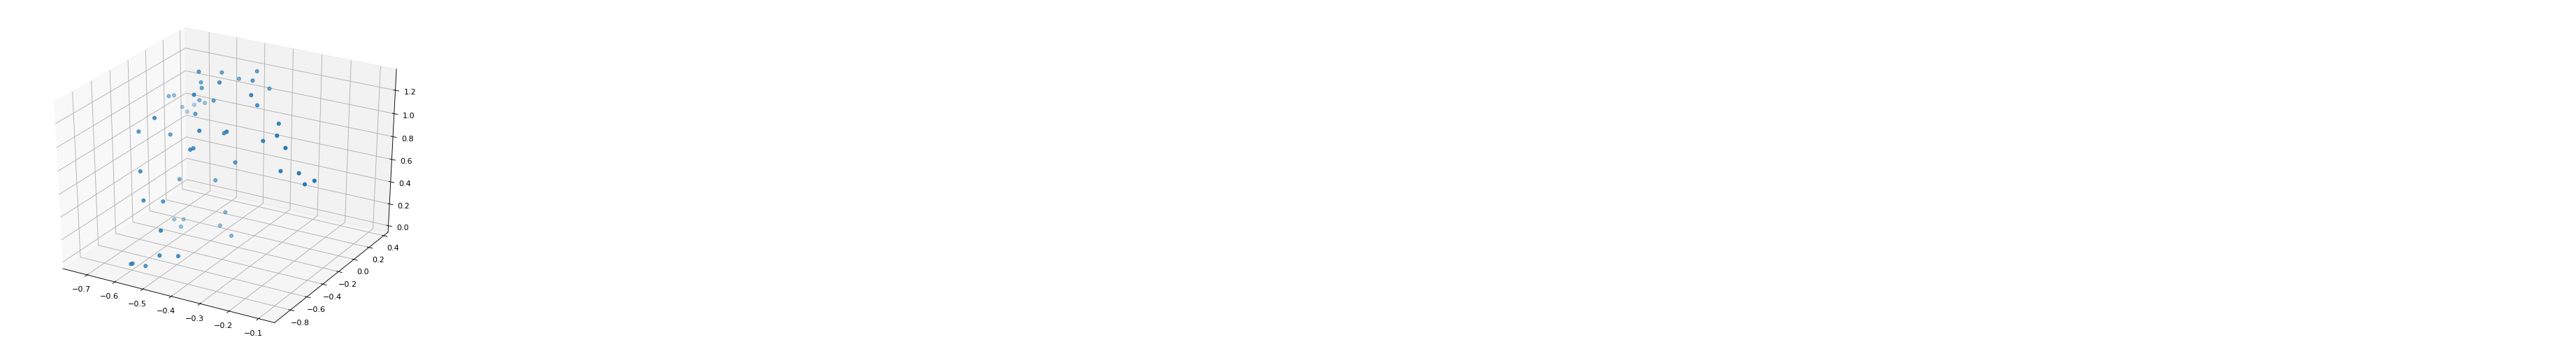

In [3]:
fig = plt.figure(num=None, figsize=(10, 8), dpi=80)
ax = fig.add_subplot(111, projection='3d')
timestamp=2500
xs = X[:,timestamp,0]
ys = X[:,timestamp,1]
zs = X[:,timestamp,2]
ax.scatter(xs, ys, zs, marker='o')
plt.show()

In [4]:
# train_x has shape: n_samples, look_back, n_vertices*3
look_back = 50 # number of previous time slices to use to predict the time positions at time `i`
train_x = []
train_y = []

# each i is a time slice; these time slices start at idx `look_back` (so we can look back `look_back` slices)
for i in range(look_back, n_timeframes-1, 1):
    train_x.append(X[:,i-look_back:i,:])
    train_y.append(X[:,i:i+1,:] )

len(train_x)
train_x = np.array(train_x)
train_y = np.concatenate(train_y, axis=1)
train_x.shape, train_y.shape

((8436, 55, 50, 3), (55, 8436, 3))

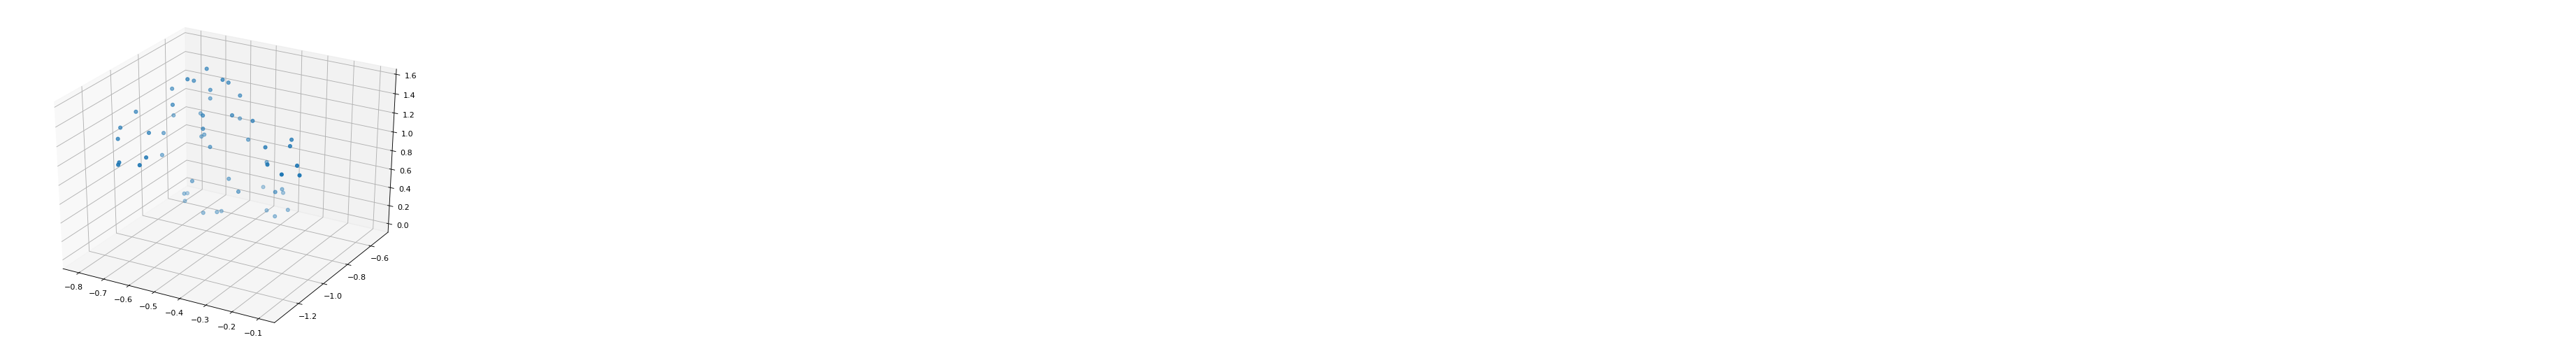

In [5]:
# Plot the predicted frame after this to make sure the target data looks right

fig = plt.figure(num=None, figsize=(10, 8), dpi=80)
ax = fig.add_subplot(111, projection='3d')

xs = train_y[:,2000,0]
ys = train_y[:,2000,1]
zs = train_y[:,2000,2]

ax.scatter(xs, ys, zs, marker='o')

# Prepare data for PCA
### Move each frame to (x,y)=(0,0), leaving the z dimension free

In [6]:
print(X.shape)
X[:,:,:2] -= X[:,:,:2].mean(axis=0, keepdims=True)

(55, 8487, 3)


### Then "flatten" dimensions, i.e. instead of n timestamps x 55 joints x 3 dimensions, use n timestamps x 165 joints

In [7]:
print(X.shape)
# reshape such that flattened.shape = time, [x0, y0, z0, x1, y1, z1, ... xn-1, yn-1, zn-1]
flat = X.swapaxes(0, 1).reshape( (X.shape[1], X.shape[0] * X.shape[2]), order='C' )
print(flat.shape)

(55, 8487, 3)
(8487, 165)


In [8]:
column_names = [ 'joint'+str(i)+'_'+str(j) for i in range(int(flat.shape[1]/3)) for j in ['x','y','z']]
column_names

['joint0_x',
 'joint0_y',
 'joint0_z',
 'joint1_x',
 'joint1_y',
 'joint1_z',
 'joint2_x',
 'joint2_y',
 'joint2_z',
 'joint3_x',
 'joint3_y',
 'joint3_z',
 'joint4_x',
 'joint4_y',
 'joint4_z',
 'joint5_x',
 'joint5_y',
 'joint5_z',
 'joint6_x',
 'joint6_y',
 'joint6_z',
 'joint7_x',
 'joint7_y',
 'joint7_z',
 'joint8_x',
 'joint8_y',
 'joint8_z',
 'joint9_x',
 'joint9_y',
 'joint9_z',
 'joint10_x',
 'joint10_y',
 'joint10_z',
 'joint11_x',
 'joint11_y',
 'joint11_z',
 'joint12_x',
 'joint12_y',
 'joint12_z',
 'joint13_x',
 'joint13_y',
 'joint13_z',
 'joint14_x',
 'joint14_y',
 'joint14_z',
 'joint15_x',
 'joint15_y',
 'joint15_z',
 'joint16_x',
 'joint16_y',
 'joint16_z',
 'joint17_x',
 'joint17_y',
 'joint17_z',
 'joint18_x',
 'joint18_y',
 'joint18_z',
 'joint19_x',
 'joint19_y',
 'joint19_z',
 'joint20_x',
 'joint20_y',
 'joint20_z',
 'joint21_x',
 'joint21_y',
 'joint21_z',
 'joint22_x',
 'joint22_y',
 'joint22_z',
 'joint23_x',
 'joint23_y',
 'joint23_z',
 'joint24_x',
 'joint2

In [116]:
df = pd.DataFrame(flat, columns=column_names)
print('Size of the dataframe: {}'.format(df.shape))
df

Size of the dataframe: (8487, 165)


,joint0_x,joint0_y,joint0_z,joint1_x,joint1_y,joint1_z,joint2_x,joint2_y,joint2_z,joint3_x,...,joint51_z,joint52_x,joint52_y,joint52_z,joint53_x,joint53_y,joint53_z,joint54_x,joint54_y,joint54_z
0,0.023354,0.002229,1.653956,-0.080424,-0.047560,1.383995,0.083782,0.051757,1.285675,0.102856,...,1.182330,0.095189,0.075907,1.152767,0.025507,-0.038550,0.857478,-0.060858,-0.115378,1.183240
1,0.023354,0.002229,1.653956,-0.080424,-0.047560,1.383995,0.083782,0.051757,1.285675,0.102856,...,1.182330,0.095189,0.075907,1.152767,0.025507,-0.038550,0.857478,-0.060858,-0.115378,1.183240
2,0.023354,0.002229,1.653956,-0.080424,-0.047560,1.383995,0.083782,0.051757,1.285675,0.102856,...,1.182330,0.095189,0.075907,1.152767,0.025507,-0.038550,0.857478,-0.060858,-0.115378,1.183240
3,0.023354,0.002229,1.653956,-0.080424,-0.047560,1.383995,0.083782,0.051757,1.285675,0.102856,...,1.182330,0.095189,0.075907,1.152767,0.025507,-0.038550,0.857478,-0.060858,-0.115378,1.183240
4,0.023354,0.002229,1.653956,-0.080424,-0.047560,1.383995,0.083782,0.051757,1.285675,0.102856,...,1.182330,0.095189,0.075907,1.152767,0.025507,-0.038550,0.857478,-0.060858,-0.115378,1.183240
5,0.023354,0.002229,1.653956,-0.080424,-0.047560,1.383995,0.083782,0.051757,1.285675,0.102856,...,1.182330,0.095189,0.075907,1.152767,0.025507,-0.038550,0.857478,-0.060858,-0.115378,1.183240
6,0.023354,0.002229,1.653956,-0.080424,-0.047560,1.383995,0.083782,0.051757,1.285675,0.102856,...,1.182330,0.095189,0.075907,1.152767,0.025507,-0.038550,0.857478,-0.060858,-0.115378,1.183240
7,0.023354,0.002229,1.653956,-0.080424,-0.047560,1.383995,0.083782,0.051757,1.285675,0.102856,...,1.182330,0.095189,0.075907,1.152767,0.025507,-0.038550,0.857478,-0.060858,-0.115378,1.183240
8,0.023354,0.002229,1.653956,-0.080424,-0.047560,1.383995,0.083782,0.051757,1.285675,0.102856,...,1.182330,0.095189,0.075907,1.152767,0.025507,-0.038550,0.857478,-0.060858,-0.115378,1.183240
9,0.023354,0.002229,1.653956,-0.080424,-0.047560,1.383995,0.083782,0.051757,1.285675,0.102856,...,1.182330,0.095189,0.075907,1.152767,0.025507,-0.038550,0.857478,-0.060858,-0.115378,1.183240


In [10]:
random_permutation = np.random.permutation(df.shape[0])
random_permutation

array([ 458, 7566, 3810, ..., 3151, 6929, 6114])

# First, we'll use PCA:

Explained variation per principal component: [0.5469125  0.18935123]


Text(0, 0.5, 'pca_1')

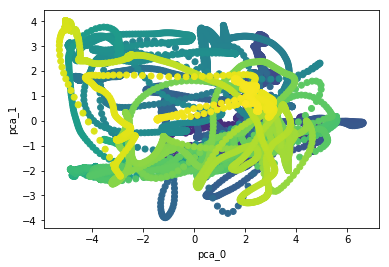

In [124]:
from sklearn.decomposition import PCA

pca = PCA(n_components=2) # can either do this by num of desired components...
# pca = PCA(.95) # ...or by percentage variance you want explained 

pca_columns=[]

pca_result = pca.fit_transform(df.values)
for i in range(pca_result.shape[1]):
    df['pca_'+str(i)] = pca_result[:,i]
    pca_columns.append('pca_'+str(i))
    
print('Explained variation per principal component: {}'.format(pca.explained_variance_ratio_))

# Plot just the first two dimensions in PCA space
plt.scatter(df.loc[:,"pca_0"],df.loc[:,"pca_1"],c=np.arange(len(df)),cmap='viridis')
plt.xlabel("pca_0")
plt.ylabel("pca_1")

In [127]:
# Get the transformed dataset 
print(df[pca_columns].shape)
df[pca_columns]

(8487, 2)


,pca_0,pca_1
0,2.466801,-1.261308
1,2.466801,-1.261308
2,2.466801,-1.261308
3,2.466801,-1.261308
4,2.466801,-1.261308
5,2.466801,-1.261308
6,2.466801,-1.261308
7,2.466801,-1.261308
8,2.466801,-1.261308
9,2.466801,-1.261308


Training then happens here, on the reduced-dimensionality dataset. 

Then, just for practice, let's try reversing this process and reconstructing original coordinates from the compressed coordinates:

In [128]:
print("Compressed shape", df[pca_columns].shape)
reconstructed_data=np.dot(df[pca_columns], pca.components_)
print("Reconstructed shape", reconstructed_data.shape)

Compressed shape (8487, 2)
Reconstructed shape (8487, 167)


Now plot an example of a compressed shape and a reconstructed shape:

---

# Compare poses from two nearly-overlapping points in this phase space:

Pick a random point:

In [145]:
pose1_index = np.random.choice(len(df))
print(pose1_index)

3833


Find the closest point to this point in the compressed dataset that isn't the original point: 

In [146]:
# Calculate each frame's distance from pose1 in the compressed space
distance=[]
for i in range(len(df)):
    distance.append(np.linalg.norm(df.loc[pose1_index,pca_columns] - df.loc[i,pca_columns]))

# Add a column to the dataframe with this distance
df["distance"]=distance

In [148]:
# look at points that have very small distances but aren't near the original sequence
df.loc[df["distance"]<.3]

,joint0_x,joint0_y,joint0_z,joint1_x,joint1_y,joint1_z,joint2_x,joint2_y,joint2_z,joint3_x,...,joint52_z,joint53_x,joint53_y,joint53_z,joint54_x,joint54_y,joint54_z,pca_0,pca_1,distance
1065,0.043272,-0.057132,1.621126,0.076070,0.081755,1.347145,-0.022603,-0.050572,1.269014,-0.237781,...,1.134727,0.024318,0.024091,0.833634,0.032080,0.192633,1.214228,2.186275,0.455880,0.271488
1066,0.039533,-0.060057,1.617616,0.068684,0.083199,1.343595,-0.031162,-0.048085,1.267784,-0.216164,...,1.133912,0.014329,0.018857,0.832155,0.020317,0.188720,1.209510,2.161383,0.445542,0.247460
1067,0.038517,-0.061764,1.616496,0.065292,0.085631,1.344188,-0.036094,-0.046784,1.268629,-0.190383,...,1.135191,0.006599,0.016063,0.832383,0.011560,0.185720,1.209468,2.159036,0.433136,0.236431
1068,0.035878,-0.065077,1.616415,0.062009,0.082511,1.347098,-0.037730,-0.047060,1.270210,-0.155376,...,1.137140,0.002127,0.017940,0.834602,0.010731,0.193026,1.214858,2.184454,0.410821,0.238430
1069,0.033109,-0.070697,1.618720,0.064067,0.085281,1.352427,-0.033269,-0.045908,1.272145,-0.118582,...,1.139099,0.001561,0.026566,0.838506,0.007429,0.197121,1.221961,2.226413,0.370404,0.250144
1070,0.032221,-0.076763,1.621615,0.067506,0.088999,1.358045,-0.025564,-0.043649,1.276162,-0.081613,...,1.142931,0.005018,0.035204,0.843921,0.005115,0.199296,1.229038,2.283273,0.336128,0.290041
1242,0.091030,-0.008681,1.622784,-0.031428,-0.102074,1.345212,0.079681,0.041429,1.274179,-0.240022,...,1.141403,-0.008575,-0.000360,0.840079,-0.069425,-0.115898,1.164362,1.737078,0.199844,0.273480
1243,0.089775,-0.005034,1.629220,-0.035586,-0.105475,1.352521,0.078925,0.037677,1.281678,-0.212593,...,1.148759,-0.011784,-0.000454,0.847412,-0.074209,-0.114810,1.171430,1.797557,0.228620,0.209166
1244,0.090385,-0.002038,1.634055,-0.041758,-0.110403,1.360083,0.076579,0.032638,1.287986,-0.174122,...,1.154638,-0.019434,-0.003703,0.854560,-0.083265,-0.113108,1.179030,1.875889,0.253228,0.129341
1245,0.089130,-0.001167,1.637328,-0.044926,-0.125193,1.366873,0.072060,0.028357,1.291961,-0.123656,...,1.158424,-0.027940,-0.008973,0.859441,-0.091968,-0.114064,1.185267,1.958463,0.266085,0.048411


Choose one that isn't near pose_1 in time:

In [153]:
pose2_index = 1242

Now plot them as static poses:

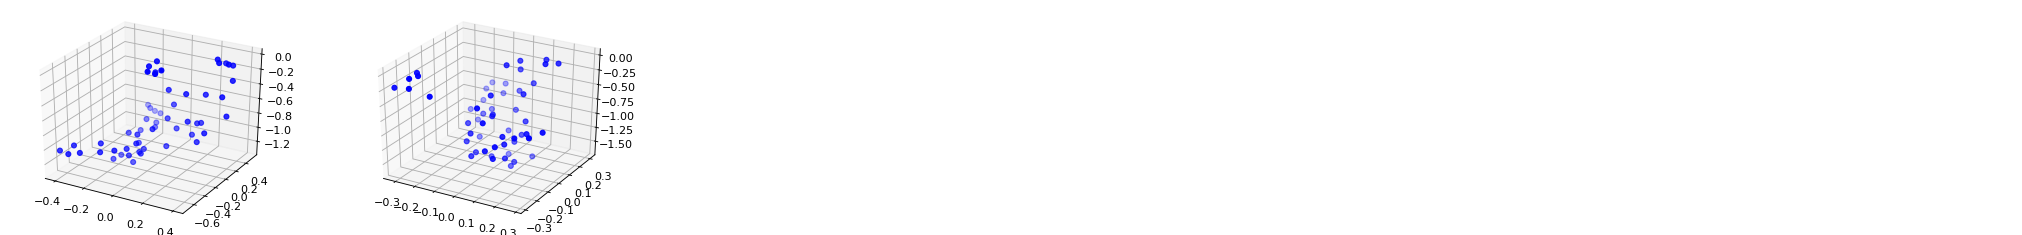

In [154]:
pose1 = df.loc[pose1_index]
pose2 = df.loc[pose2_index]

fig = plt.figure(num=None, figsize=(10, 8), dpi=80)

ax_1 = fig.add_subplot(221, projection='3d')
xs_1 = pose1.loc[column_names][0::3]
ys_1 = pose1.loc[column_names][1::3]
zs_1 = pose1.loc[column_names][2::3]
ax_1.scatter(xs_1, ys_1, -zs_1, marker='o', c='blue')

ax_2 = fig.add_subplot(222, projection='3d')
xs_2 = pose2.loc[column_names][0::3]
ys_2 = pose2.loc[column_names][1::3]
zs_2 = pose2.loc[column_names][2::3]
ax_2.scatter(xs_2, ys_2, -zs_2, marker='o', c='blue')

...and as sequences:

/usr/local/lib/python3.7/site-packages/matplotlib/__init__.py:886: MatplotlibDeprecationWarning: 
examples.directory is deprecated; in the future, examples will be found relative to the 'datapath' directory.
  "found relative to the 'datapath' directory.".format(key))


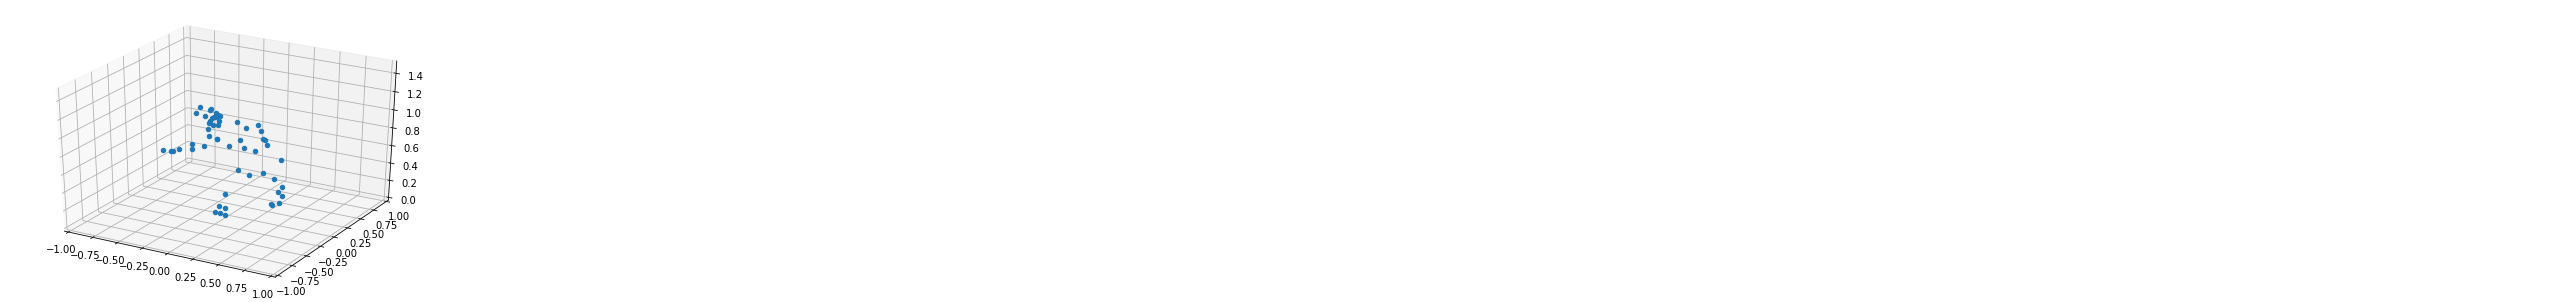

In [157]:
poses1 = df.loc[pose1_index:pose1_index+5,column_names]
poses2 = df.loc[pose2_index:pose2_index+5,column_names]
poses1_np = poses1.values
poses2_np = poses2.values

HTML(get_plot(poses1_np, frames=len(poses1_np),run_tests=False))

/usr/local/lib/python3.7/site-packages/matplotlib/__init__.py:886: MatplotlibDeprecationWarning: 
examples.directory is deprecated; in the future, examples will be found relative to the 'datapath' directory.
  "found relative to the 'datapath' directory.".format(key))


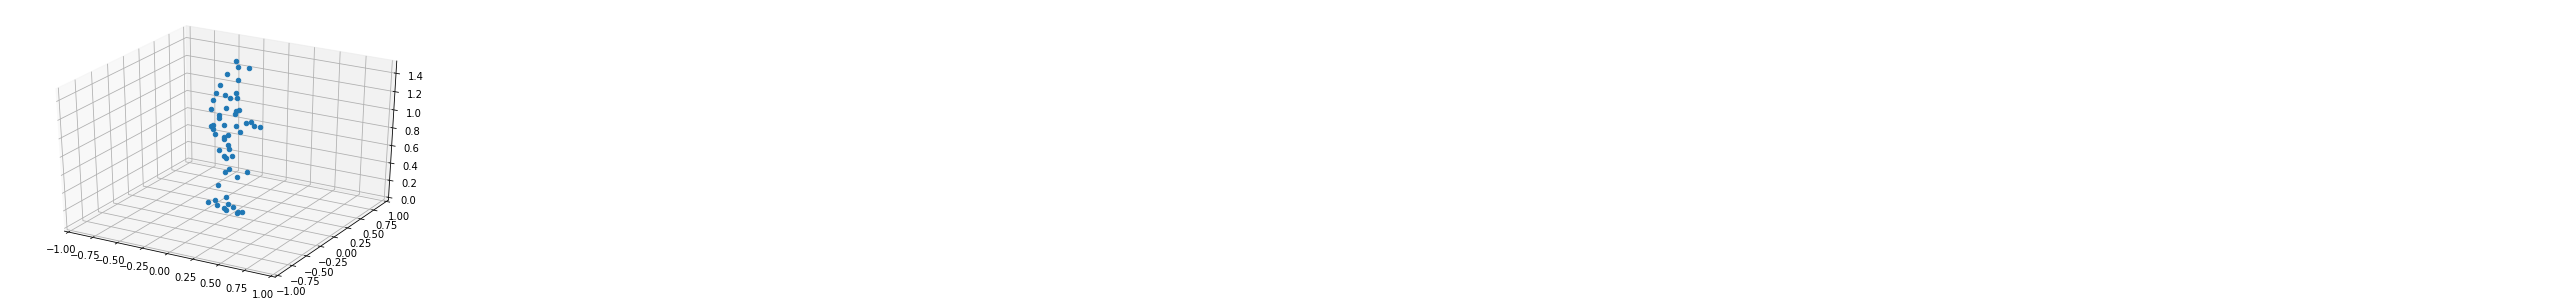

In [158]:
HTML(get_plot(poses2_np, frames=len(poses2_np),run_tests=False))

### Interpolate on a line in PCA space

Pick two endpoints for the line in (pca_0, pca_1) coordinates:

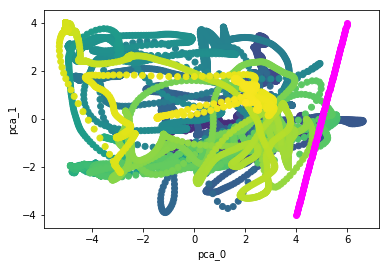

In [232]:
line_start = (4,-4)
line_end = (6,4)

interp_x = np.linspace(line_start[0],line_end[0],100)
interp_y = np.interp(interp_x, [line_start[0],line_end[0]], [line_start[1],line_end[1]])

plt.scatter(df.loc[:,"pca_0"],df.loc[:,"pca_1"],c=np.arange(len(df)),cmap='viridis')
plt.xlabel("pca_0")
plt.ylabel("pca_1")
plt.scatter(interp_x,interp_y,color='magenta')
plt.show()

/usr/local/lib/python3.7/site-packages/matplotlib/__init__.py:886: MatplotlibDeprecationWarning: 
examples.directory is deprecated; in the future, examples will be found relative to the 'datapath' directory.
  "found relative to the 'datapath' directory.".format(key))


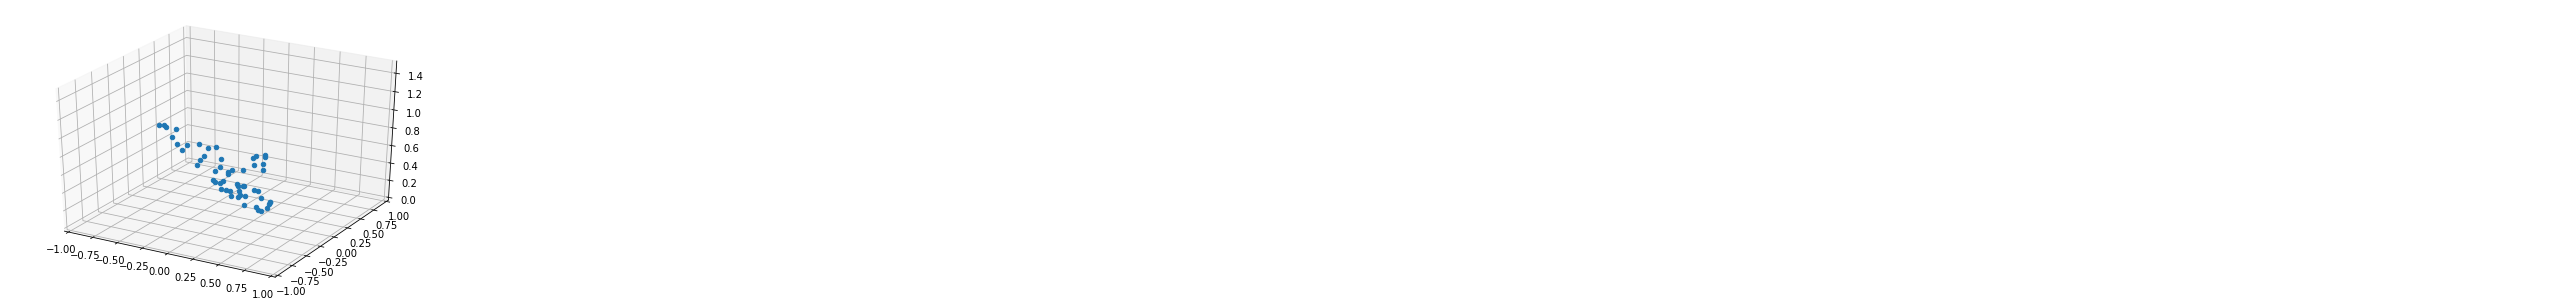

In [233]:
interp = np.vstack((interp_x,interp_y)).T
pca_interp=np.dot(interp, pca.components_)
pca_interp[:,:165].shape # only use 55*3 variables, i.e. actual joints instead of PCA scores

HTML(get_plot(pca_interp[:,:165], frames=len(pca_interp),run_tests=False))

### Get fancier in interpolations

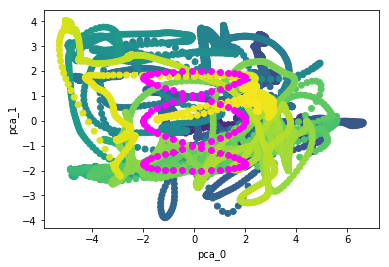

In [254]:
stroke_x = 2*np.cos(3*np.linspace(-np.pi,np.pi,100))
stroke_y = 2*np.sin(np.linspace(-np.pi,np.pi,100))

plt.scatter(df.loc[:,"pca_0"],df.loc[:,"pca_1"],c=np.arange(len(df)),cmap='viridis')
plt.xlabel("pca_0")
plt.ylabel("pca_1")
plt.scatter(stroke_x,stroke_y,color='magenta')
plt.show()

/usr/local/lib/python3.7/site-packages/matplotlib/__init__.py:886: MatplotlibDeprecationWarning: 
examples.directory is deprecated; in the future, examples will be found relative to the 'datapath' directory.
  "found relative to the 'datapath' directory.".format(key))


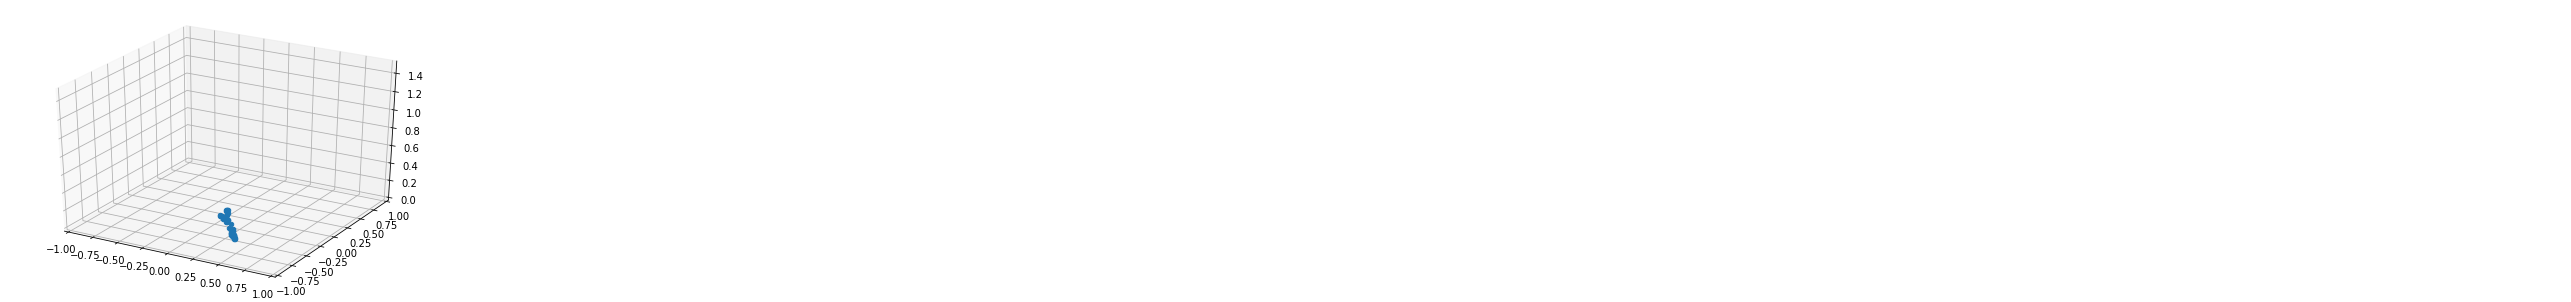

In [255]:
stroke = np.vstack((stroke_x,stroke_y)).T
pca_stroke=np.dot(stroke, pca.components_)
pca_stroke[:,:165].shape # only use 55*3 variables, i.e. actual joints instead of PCA scores

HTML(get_plot(pca_stroke[:,:165], frames=len(pca_stroke),run_tests=False))

# Next, try t-SNE:

In [159]:
import time
from sklearn.manifold import TSNE

n_sne = 7000

time_start = time.time()
tsne = TSNE(n_components=2, verbose=1, perplexity=40, n_iter=300)
tsne_results = tsne.fit_transform(df.loc[random_permutation[:n_sne]].values)

print('t-SNE done! Time elapsed: {} seconds'.format(time.time()-time_start))

[t-SNE] Computing 121 nearest neighbors...
[t-SNE] Indexed 7000 samples in 0.058s...
[t-SNE] Computed neighbors for 7000 samples in 6.074s...
[t-SNE] Computed conditional probabilities for sample 1000 / 7000
[t-SNE] Computed conditional probabilities for sample 2000 / 7000
[t-SNE] Computed conditional probabilities for sample 3000 / 7000
[t-SNE] Computed conditional probabilities for sample 4000 / 7000
[t-SNE] Computed conditional probabilities for sample 5000 / 7000
[t-SNE] Computed conditional probabilities for sample 6000 / 7000
[t-SNE] Computed conditional probabilities for sample 7000 / 7000
[t-SNE] Mean sigma: 0.000000
[t-SNE] KL divergence after 250 iterations with early exaggeration: 63.316429
[t-SNE] KL divergence after 300 iterations: 1.610044
t-SNE done! Time elapsed: 52.89851379394531 seconds


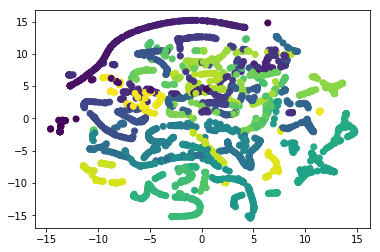

In [160]:
df_tsne = df.loc[random_permutation[:n_sne],:].copy()
df_tsne['x-tsne'] = tsne_results[:,0]
df_tsne['y-tsne'] = tsne_results[:,1]

colors = random_permutation[:3000]
plt.scatter(df_tsne.loc[random_permutation[:3000],"x-tsne"], df_tsne.loc[random_permutation[:3000],"y-tsne"],c=colors,cmap='viridis')

In [171]:
print(tsne_results.shape)
df_tsne[["x-tsne","y-tsne"]]

(7000, 2)


,x-tsne,y-tsne
458,-10.104060,7.934560
7566,1.065337,6.952948
3810,-5.549621,-6.045842
483,-9.691829,8.664817
7131,1.245138,8.789044
4634,2.101886,-9.355947
4011,2.424542,-1.382784
2695,10.724950,-1.942737
3815,-6.159921,-7.209996
5477,-5.437997,-12.015335


# Now try t-SNE after dimensionality reduction from PCA:

In [ ]:
pca_10 = PCA(n_components=10)
pca_result_10 = pca_10.fit_transform(df.values)
print('Cumulative explained variation for 10 principal components: {}'.format(np.sum(pca_10.explained_variance_ratio_)))

In [ ]:
n_sne = 10000
time_start = time.time()
tsne = TSNE(n_components=2, verbose=1, perplexity=40, n_iter=300)
tsne_pca_results = tsne.fit_transform(pca_result_10[random_permutation[:n_sne]])

print('t-SNE done! Time elapsed: {} seconds'.format(time.time()-time_start))

In [ ]:
df_tsne = None
df_tsne = df.loc[random_permutation[:n_sne],:].copy()
df_tsne['x-tsne-pca'] = tsne_pca_results[:,0]
df_tsne['y-tsne-pca'] = tsne_pca_results[:,1]

colors = random_permutation[:3000]
plt.scatter(df_tsne.loc[random_permutation[:3000],"x-tsne-pca"], df_tsne.loc[random_permutation[:3000],"y-tsne-pca"],c=colors,cmap='viridis')

In [ ]:
tsne_pca_results.shape